In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from collections import defaultdict
from sklearn.svm import SVC
from tqdm import tqdm
from scipy.optimize import brute, fmin

from src.utils.utils import MyLightningCLI, TrainerWandb, get_X_y_groups, PenalizedBinaryFBetaScore
from src.scripts.runs_info import get_runs_info

# Find weights for weighted average ensembling

Use nested CV: inner loop to select best patch attention model, outer to actually find ensemble weights.

Best params from HPO

In [3]:
max_epochs = 200  # set to 3 for debugging
best_pac_params = f'--data.init_args.batch_size=32 --data.init_args.sampler=weighted_upsampling --model.init_args.attention_dropout=0.1101479509435598 --model.init_args.attention_hidden_dim=64 --model.init_args.attention_num_heads=8 --model.init_args.label_smoothing=0.19365209170598277 --model.lr=0.0008549720251132047 --trainer.max_epochs={max_epochs}'

Training is done separately due to better parallelization when running it as script. 
Run command of train is:

```
python run/main_cv.py fit --config run/configs/swin-patch-attention-classifier.yaml --data.init_args.batch_size=32 --data.init_args.sampler=weighted_upsampling --model.init_args.attention_dropout=0.1101479509435598 --model.init_args.attention_hidden_dim=64 --model.init_args.attention_num_heads=8 --model.init_args.label_smoothing=0.19365209170598277 --model.lr=0.0008549720251132047 --trainer.max_epochs=200 --data.init_args.k_test 5 --data.init_args.fold_index_test {fold_index_test}
```

Assuming trained models for each fold in nested CV are in `./visiomel` dir and wandb logs are in `./wandb`, extract checkpoint info.

In [4]:
def oldest_checkpoint(filenames):
    filenames = [filename for filename in filenames if 'epoch' in filename]
    # format is epoch={epoch}-step={step}.ckpt
    # get path with largest step
    return sorted(filenames, key=lambda x: int(x.split('=')[2].split('.')[0]))[-1]

runs_info = get_runs_info(Path('/workspace/visiomel-2023/visiomel'), Path('/workspace/visiomel-2023/wandb'))
fold_to_ckpt_path = defaultdict(dict)
for run_info in runs_info.values():
    fold_to_ckpt_path[run_info['fold_index_test']][run_info['fold_index']] = oldest_checkpoint(
        run_info['checkpoint_paths']
    )

In [5]:
runs_info

{'6cuv726l': {'fold_index_test': 3,
  'fold_index': 3,
  'checkpoint_paths': ['/workspace/visiomel-2023/visiomel/6cuv726l/checkpoints/last.ckpt',
   '/workspace/visiomel-2023/visiomel/6cuv726l/checkpoints/epoch=26-step=6615.ckpt']},
 '6d4yat82': {'fold_index_test': 4,
  'fold_index': 4,
  'checkpoint_paths': ['/workspace/visiomel-2023/visiomel/6d4yat82/checkpoints/last.ckpt',
   '/workspace/visiomel-2023/visiomel/6d4yat82/checkpoints/epoch=22-step=5589.ckpt']},
 'vblrz6h2': {'fold_index_test': 0,
  'fold_index': 0,
  'checkpoint_paths': ['/workspace/visiomel-2023/visiomel/vblrz6h2/checkpoints/last.ckpt',
   '/workspace/visiomel-2023/visiomel/vblrz6h2/checkpoints/epoch=2-step=732.ckpt']},
 'yvtlj7ne': {'fold_index_test': 4,
  'fold_index': 0,
  'checkpoint_paths': ['/workspace/visiomel-2023/visiomel/yvtlj7ne/checkpoints/last.ckpt',
   '/workspace/visiomel-2023/visiomel/yvtlj7ne/checkpoints/epoch=90-step=22204.ckpt']},
 'zjq0fvtb': {'fold_index_test': 0,
  'fold_index': 4,
  'checkpoint_

Optimize the weighted probability average ensembling of 
- patch attention model (prediction on outer CV val dataset is mean of 5 models of inner CV predicted probabilities)
- SVC model (prediction on outer CV is just prediction of single model trained on full inner CV dataset including train and val)

In [6]:
def optimize_weights(probas: np.ndarray, target: np.ndarray, step=0.01):
    """"Maximize the penalized F1 score of weighted average of probas"""
    
    def f(weights):
        weights = np.append(weights, 1 - weights.sum())
        scorer = PenalizedBinaryFBetaScore('soft', beta=1.0)
        wa_proba = (torch.tensor(probas) * torch.tensor(weights)[None, :]).sum(1)
        scorer.update(wa_proba, torch.tensor(target))
        return -scorer.compute().item()
    
    ranges = (slice(0, 1, step),) * (probas.shape[1] - 1)
    argmax_score_w, max_score, *_ = brute(f, ranges=ranges, finish=fmin, full_output=True)
    
    return -max_score, argmax_score_w

In [9]:
outer_cv_results = defaultdict(dict)
for outer_fold_index in tqdm(range(5)):
    data = defaultdict(dict)
    for inner_fold_index in tqdm(range(5)):
        cli = MyLightningCLI(
            trainer_class=TrainerWandb, 
            save_config_kwargs={
                'config_filename': 'config_pl.yaml',
                'overwrite': True,
            },
            args=[
                '--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml',
                *best_pac_params.split(),
                '--data.init_args.k', '5',
                '--data.init_args.fold_index', f'{inner_fold_index}',
                '--data.init_args.k_test', '5',
                '--data.init_args.fold_index_test', f'{outer_fold_index}',
                '--data.init_args.num_workers', '10',
                '--data.init_args.num_workers_saturated', '10',
            ],
            run=False,
        )

        # Patch attention model
        y_proba = torch.softmax(
            torch.concat(
                cli.trainer.predict(
                    model=cli.model,
                    datamodule=cli.datamodule, 
                    return_predictions=True,
                    ckpt_path=fold_to_ckpt_path[outer_fold_index][inner_fold_index],
                ), 
                dim=0
            ).float(), 
            dim=1
        ).numpy()
        data['pac'][inner_fold_index] = y_proba[:, 1]

    # Single SVC model on embeddings on outer train data
    clf = SVC(kernel='linear', C=0.01, probability=True, class_weight='balanced', random_state=0)
    # train + val & test are same for each inner fold, so just use last cli here
    X, y, _ = get_X_y_groups(pd.concat([cli.datamodule.train_dataset.data, cli.datamodule.val_dataset.data]))
    X_test, y_test, _ = get_X_y_groups(cli.datamodule.test_dataset.data)
    clf.fit(X, y)
    y_proba = clf.predict_proba(X_test)
    data['svc'][-1] = y_proba[:, 1]

    # Ground truth
    data['gt'][-1] = y_test

    # Ensemble
    df = pd.DataFrame(
        {
            'pac': sum(data['pac'].values()) / len(data['pac']),
            'svc': data['svc'][-1],
            'gt': data['gt'][-1],
        }
    )
    max_score, argmax_score_w = optimize_weights(df[['pac', 'svc']].values, df['gt'].values)
    outer_cv_results[outer_fold_index]['max_score'] = max_score
    outer_cv_results[outer_fold_index]['argmax_score_w'] = argmax_score_w
    outer_cv_results[outer_fold_index]['df'] = df
    outer_cv_results[outer_fold_index]['data'] = data

  0%|          | 0/5 [00:00<?, ?it/s]/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sampler=weighted_upsampling', '--model.init_args.attention_dropout=0.1101479509435598', '--model.init_args.attention_hidden_dim=64', '--model.init_args.attention_num_heads=8', '--model.init_args

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /workspace/visiomel-2023/visiomel/vblrz6h2/checkpoints/epoch=2-step=732.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /workspace/visiomel-2023/visiomel/vblrz6h2/checkpoints/epoch=2-step=732.ckpt


Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 20%|██        | 1/5 [00:32<02:11, 32.90s/it]/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 40%|████      | 2/5 [00:57<01:24, 28.01s/it]/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 60%|██████    | 3/5 [01:22<00:52, 26.47s/it]/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 80%|████████  | 4/5 [01:46<00:25, 25.71s/it]/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/pytorch_lightning/cli.py:484: UserWarning: LightningCLI's args parameter is intended to run from within Python like if it were from the command line. To prevent mistakes it is not recommended to provide both args and command line arguments, got: sys.argv[1:]=['--ip=127.0.0.1', '--stdin=9003', '--control=9001', '--hb=9000', '--Session.signature_scheme="hmac-sha256"', '--Session.key=b"de075e14-9ad3-41b7-a5f2-5387e1eb72b5"', '--shell=9002', '--transport="tcp"', '--iopub=9004', '--f=/root/.local/share/jupyter/runtime/kernel-v2-2552482MB5ow10vQkDe.json'], args=['--config', '/workspace/visiomel-2023/run/configs/swin-patch-attention-classifier.yaml', '--data.init_args.batch_size=32', '--data.init_args.sample

Predicting: 0it [00:00, ?it/s]

/root/miniconda3/envs/visiomel-2023/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 5/5 [02:11<00:00, 26.27s/it]


In [7]:
import pickle

In [8]:
with open('outer_cv_results.pkl', 'rb') as f:
    outer_cv_results = pickle.load(f)

In [10]:
outer_cv_results[3]['data']['pac'][3]

array([0.5051878 , 0.4889849 , 0.52375525, 0.37196323, 0.45208988,
       0.45508513, 0.31547233, 0.49707034, 0.50985587, 0.49211186,
       0.34745404, 0.4964295 , 0.5554691 , 0.70952255, 0.56685793,
       0.49827576, 0.4678788 , 0.4584093 , 0.33657634, 0.47704402,
       0.46962664, 0.46691018, 0.4919746 , 0.70755625, 0.6637507 ,
       0.4870787 , 0.41332912, 0.71133065, 0.49432397, 0.45872372,
       0.70288706, 0.51299757, 0.55433476, 0.69551903, 0.5151016 ,
       0.49523938, 0.4291303 , 0.59927994, 0.47951126, 0.5068355 ,
       0.48896208, 0.6245512 , 0.49705505, 0.50314325, 0.47452465,
       0.690246  , 0.44943795, 0.49853516, 0.3406017 , 0.7061904 ,
       0.6859495 , 0.69029814, 0.4144007 , 0.35919464, 0.5784929 ,
       0.24673748, 0.22177178, 0.22901753, 0.26623803, 0.6797902 ,
       0.409944  , 0.47597066, 0.6709857 , 0.22644134, 0.361538  ,
       0.56132007, 0.25893456, 0.51363796, 0.303706  , 0.24558224,
       0.5581765 , 0.62981063, 0.23014024, 0.66285104, 0.48136

In [11]:
with open('outer_cv_results.pkl', 'wb') as f:
    pickle.dump(outer_cv_results, f)

In [12]:
for outer_fold_index in range(5):
    print(outer_cv_results[outer_fold_index]['max_score'], outer_cv_results[outer_fold_index]['argmax_score_w'])

0.43609023094177246 [1.002375]
0.4521739184856415 [0.9440625]
0.2885153889656067 [0.95]
0.4188494384288788 [0.7850625]
0.49056604504585266 [0.96]


# Final train

In [18]:
for outer_fold_index in tqdm(range(5)):
    # Ensemble
    df = outer_cv_results[outer_fold_index]['df']
    max_score, argmax_score_w = optimize_weights(df[['pac', 'svc']].values, df['gt'].values)
    outer_cv_results[outer_fold_index]['max_score'] = max_score
    outer_cv_results[outer_fold_index]['argmax_score_w'] = argmax_score_w

100%|██████████| 5/5 [00:00<00:00, 10.27it/s]


In [19]:
for outer_fold_index in range(5):
    print(outer_cv_results[outer_fold_index]['max_score'], outer_cv_results[outer_fold_index]['argmax_score_w'])

0.43609023094177246 [1.002375]
0.4521739184856415 [0.9440625]
0.2885153889656067 [0.95]
0.4188494384288788 [0.7850625]
0.49056604504585266 [0.96]


In [15]:
from sklearn.metrics import log_loss, f1_score
import matplotlib.pyplot as plt

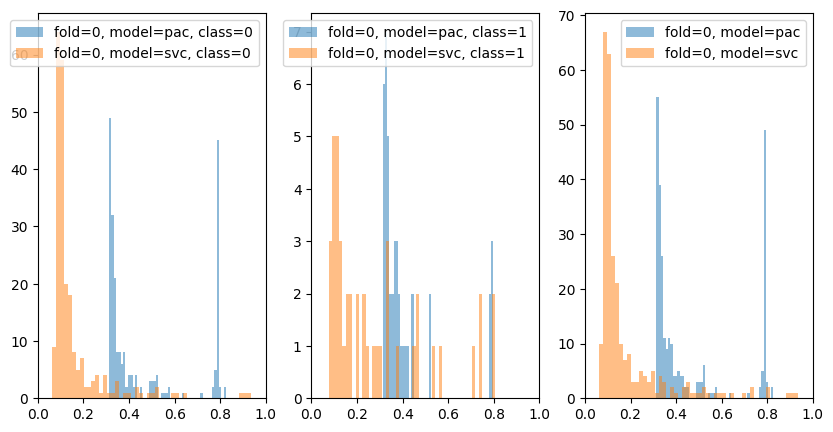

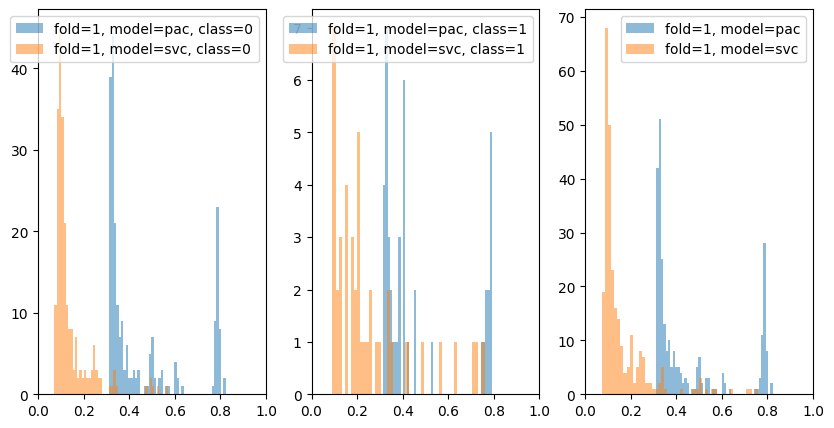

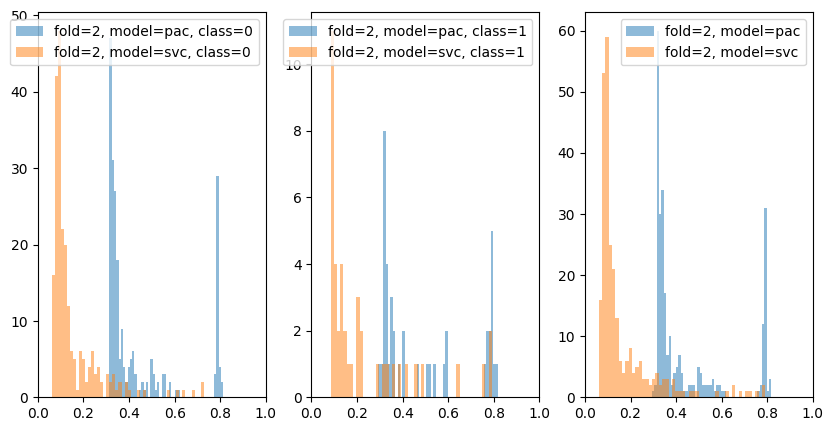

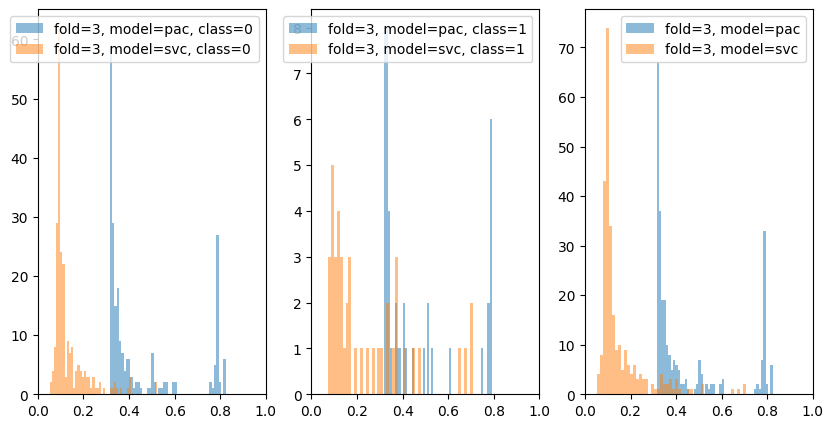

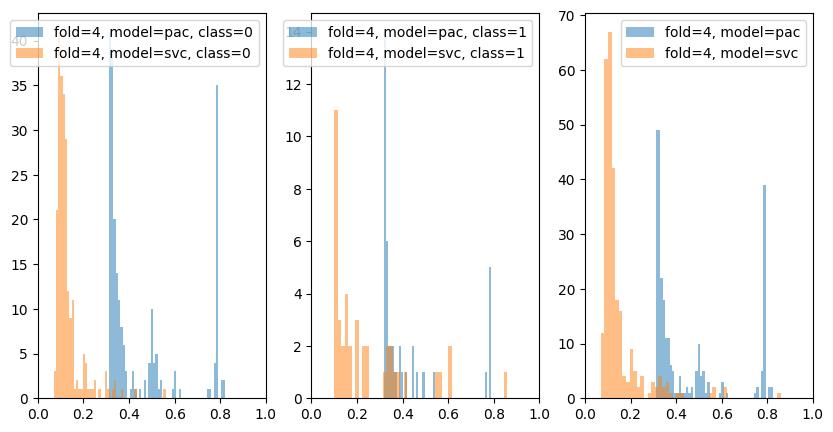

In [24]:
# plot hist of probas for each fold for each model for each class
for outer_fold_index in range(5):
    df = outer_cv_results[outer_fold_index]['df']
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    for model in ['pac', 'svc']:
        for i in [0, 1]:
            axes[i].hist(
                df[df['gt'] == i][model],
                bins=50,
                alpha=0.5,
                label=f'fold={outer_fold_index}, model={model}, class={i}',
            )
            axes[i].set_xlim(0, 1)
            axes[i].legend()
        
        axes[2].hist(
            df[model],
            bins=50,
            alpha=0.5,
            label=f'fold={outer_fold_index}, model={model}',
        )
        axes[2].set_xlim(0, 1)
        axes[2].legend()

In [16]:
for outer_fold_index in range(5):
    df = outer_cv_results[outer_fold_index]['df']
    df['pac_neg'] = 1 - df['pac']

In [28]:
# remove rows print limit
pd.set_option('display.max_rows', None)
print(outer_cv_results[0]['df'])
# reset rows print limit
pd.reset_option('display.max_rows')

          pac       svc  gt   pac_neg
0    0.782891  0.343748   0  0.217109
1    0.787114  0.101692   0  0.212886
2    0.787523  0.086199   0  0.212477
3    0.786950  0.097094   0  0.213050
4    0.785884  0.128088   0  0.214116
5    0.787850  0.104050   0  0.212150
6    0.790369  0.081114   0  0.209631
7    0.791741  0.395411   0  0.208259
8    0.787931  0.155225   0  0.212069
9    0.825414  0.209803   0  0.174586
10   0.785720  0.085553   0  0.214280
11   0.786049  0.087314   0  0.213951
12   0.794305  0.075260   0  0.205695
13   0.786377  0.093350   0  0.213623
14   0.788094  0.099419   0  0.211906
15   0.786295  0.088760   0  0.213705
16   0.786131  0.109962   0  0.213869
17   0.722282  0.500000   0  0.277718
18   0.788339  0.130171   0  0.211661
19   0.773388  0.295812   0  0.226612
20   0.785391  0.115076   0  0.214609
21   0.775392  0.381578   0  0.224608
22   0.790894  0.060070   0  0.209106
23   0.790288  0.096865   0  0.209712
24   0.791982  0.068321   0  0.208018
25   0.78980

In [20]:
for outer_fold_index in range(5):
    for model_name in ['pac', 'svc', 'pac_neg']:
        ll = log_loss(outer_cv_results[outer_fold_index]['df']['gt'], outer_cv_results[outer_fold_index]['df'][model_name], eps=1e-16)
        f1 = f1_score(outer_cv_results[outer_fold_index]['df']['gt'], outer_cv_results[outer_fold_index]['df'][model_name] > 0.5)
        print(f'model {model_name}, fold {outer_fold_index}, ll {ll}, f1 {f1}')
    
    wm_proba = (0.95 * outer_cv_results[outer_fold_index]['df']['pac'] + 0.5 * outer_cv_results[outer_fold_index]['df']['svc'])
    ll = log_loss(
        outer_cv_results[outer_fold_index]['df']['gt'], 
        wm_proba, 
        eps=1e-16
    )
    f1 = f1_score(
        outer_cv_results[outer_fold_index]['df']['gt'], 
        wm_proba > 0.5
    )
    print(f'model mean, fold {outer_fold_index}, ll {ll}, f1 {f1}')
    print()

model pac, fold 0, ll 0.6485946023663692, f1 0.43609022556390975
model svc, fold 0, ll 0.40909862772899597, f1 0.24137931034482765
model pac_neg, fold 0, ll 0.7940875976431103, f1 0.12612612612612611
model mean, fold 0, ll 1.522271166736635, f1 0.3928571428571429

model pac, fold 1, ll 0.5942741333010809, f1 0.43333333333333335
model svc, fold 1, ll 0.382830275362918, f1 0.19607843137254904
model pac_neg, fold 1, ll 0.9289063334980087, f1 0.1452991452991453
model mean, fold 1, ll 0.6991741654075277, f1 0.4055944055944056

model pac, fold 2, ll 0.653945816823709, f1 0.3125
model svc, fold 2, ll 0.4185942367242228, f1 0.15384615384615385
model pac_neg, fold 2, ll 0.824606565901812, f1 0.19642857142857142
model mean, fold 2, ll 1.5285589351353717, f1 0.31205673758865243

model pac, fold 3, ll 0.5904455317895762, f1 0.4132231404958678
model svc, fold 3, ll 0.3853786820808771, f1 0.16326530612244897
model pac_neg, fold 3, ll 0.9055068655856917, f1 0.15384615384615383
model mean, fold 3, ll 